# Proyecto 1
## Detección de ataques

In [71]:
import os.path

import pandas as pd
from pandas_profiling import ProfileReport

import utils

In [72]:
generate_reports: bool = False

In [73]:
part_1 = pd.read_csv("dataset/dataset-part1.csv")
part_2 = pd.read_csv("dataset/dataset-part2.csv")

In [74]:
df = pd.concat([part_1, part_2], ignore_index=True)

## Análisis Exploratorio

In [75]:
df.columns.values

array(['BIFLOW_DIRECTION', 'DIRECTION', 'DST_TO_SRC_SECOND_BYTES',
       'FIREWALL_EVENT', 'FIRST_SWITCHED', 'FLOW_ACTIVE_TIMEOUT',
       'FLOW_DURATION_MICROSECONDS', 'FLOW_DURATION_MILLISECONDS',
       'FLOW_END_MILLISECONDS', 'FLOW_END_SEC', 'FLOW_ID',
       'FLOW_INACTIVE_TIMEOUT', 'FLOW_START_MILLISECONDS',
       'FLOW_START_SEC', 'FRAME_LENGTH', 'IN_BYTES', 'IN_PKTS',
       'IPV4_DST_ADDR', 'IPV4_SRC_ADDR', 'L4_DST_PORT', 'L4_SRC_PORT',
       'LAST_SWITCHED', 'MAX_IP_PKT_LEN', 'MIN_IP_PKT_LEN',
       'OOORDER_IN_PKTS', 'OOORDER_OUT_PKTS', 'OUT_BYTES', 'OUT_PKTS',
       'PROTOCOL', 'PROTOCOL_MAP', 'RETRANSMITTED_IN_BYTES',
       'RETRANSMITTED_IN_PKTS', 'RETRANSMITTED_OUT_BYTES',
       'RETRANSMITTED_OUT_PKTS', 'SRC_TO_DST_SECOND_BYTES', 'TCP_FLAGS',
       'TCP_WIN_MAX_IN', 'TCP_WIN_MAX_OUT', 'TCP_WIN_MIN_IN',
       'TCP_WIN_MIN_OUT', 'TCP_WIN_MSS_IN', 'TCP_WIN_MSS_OUT',
       'TCP_WIN_SCALE_IN', 'TCP_WIN_SCALE_OUT', 'SRC_TOS', 'DST_TOS',
       'L7_PROTO_NAME', 'SAM

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12207873 entries, 0 to 12207872
Data columns (total 50 columns):
 #   Column                      Dtype 
---  ------                      ----- 
 0   BIFLOW_DIRECTION            int64 
 1   DIRECTION                   int64 
 2   DST_TO_SRC_SECOND_BYTES     object
 3   FIREWALL_EVENT              int64 
 4   FIRST_SWITCHED              int64 
 5   FLOW_ACTIVE_TIMEOUT         int64 
 6   FLOW_DURATION_MICROSECONDS  int64 
 7   FLOW_DURATION_MILLISECONDS  int64 
 8   FLOW_END_MILLISECONDS       int64 
 9   FLOW_END_SEC                int64 
 10  FLOW_ID                     int64 
 11  FLOW_INACTIVE_TIMEOUT       int64 
 12  FLOW_START_MILLISECONDS     int64 
 13  FLOW_START_SEC              int64 
 14  FRAME_LENGTH                int64 
 15  IN_BYTES                    int64 
 16  IN_PKTS                     int64 
 17  IPV4_DST_ADDR               object
 18  IPV4_SRC_ADDR               object
 19  L4_DST_PORT                 int64 
 20  

In [77]:
df.head()

,BIFLOW_DIRECTION,DIRECTION,DST_TO_SRC_SECOND_BYTES,FIREWALL_EVENT,FIRST_SWITCHED,FLOW_ACTIVE_TIMEOUT,FLOW_DURATION_MICROSECONDS,FLOW_DURATION_MILLISECONDS,FLOW_END_MILLISECONDS,FLOW_END_SEC,...,TCP_WIN_MSS_IN,TCP_WIN_MSS_OUT,TCP_WIN_SCALE_IN,TCP_WIN_SCALE_OUT,SRC_TOS,DST_TOS,L7_PROTO_NAME,SAMPLING_INTERVAL,TOTAL_FLOWS_EXP,LABEL
0,1,0,40,0,1616660040,120,339,0,1616660040010,1616660040,...,1460,0,0,0,0,0,Unknown,1,2293398,Normal flow
1,1,0,",",0,1616660040,120,0,0,1616660040068,1616660040,...,0,0,0,0,40,0,ICMP,1,2293400,Normal flow
2,1,0,104,0,1616660040,120,44725,44,1616660040114,1616660040,...,0,0,0,0,0,0,TLS,1,2293404,Normal flow
3,1,0,",",0,1616660040,120,0,0,1616660040122,1616660040,...,1440,0,8,0,40,0,Unknown,1,2293407,Normal flow
4,1,0,40,0,1616660040,120,1114,1,1616660040184,1616660040,...,0,0,0,0,0,0,TLS,1,2293409,Normal flow


In [78]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
BIFLOW_DIRECTION,12207873.0,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
DIRECTION,12207873.0,2.158525e-03,4.640976e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
FIREWALL_EVENT,12207873.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
FIRST_SWITCHED,12207873.0,1.617770e+09,7.090651e+05,1.616660e+09,1.616673e+09,1.618222e+09,1.618232e+09,1.618262e+09
FLOW_ACTIVE_TIMEOUT,12207873.0,1.200000e+02,0.000000e+00,1.200000e+02,1.200000e+02,1.200000e+02,1.200000e+02,1.200000e+02
FLOW_DURATION_MICROSECONDS,12207873.0,2.162737e+07,3.997485e+07,0.000000e+00,4.610000e+02,2.998000e+04,1.373936e+07,1.199999e+08
FLOW_DURATION_MILLISECONDS,12207873.0,2.162695e+04,3.997481e+04,0.000000e+00,0.000000e+00,2.900000e+01,1.373900e+04,1.199990e+05
FLOW_END_MILLISECONDS,12207873.0,1.617770e+12,7.090782e+08,1.616660e+12,1.616673e+12,1.618222e+12,1.618232e+12,1.618263e+12
FLOW_END_SEC,12207873.0,1.617770e+09,7.090782e+05,1.616660e+09,1.616673e+09,1.618222e+09,1.618232e+09,1.618263e+09
FLOW_ID,12207873.0,5.890479e+07,3.531791e+07,2.293398e+06,5.345536e+06,7.978476e+07,8.283673e+07,8.588870e+07


In [79]:
df.describe(include=['object'])

,DST_TO_SRC_SECOND_BYTES,IPV4_DST_ADDR,IPV4_SRC_ADDR,PROTOCOL_MAP,SRC_TO_DST_SECOND_BYTES,L7_PROTO_NAME,LABEL
count,12207873,12207873,12207873,12207873,12207873,12207873,12207873
unique,569243,440887,88463,5,3160289,457,4
top,40,10.114.224.65,10.114.241.166,tcp,44,Unknown,Normal flow
freq,3053652,3604686,5671376,8950058,2534718,4090802,6570058


In [80]:
object_columns = df.select_dtypes(include=['object']).columns
df[object_columns].head(10)

,DST_TO_SRC_SECOND_BYTES,IPV4_DST_ADDR,IPV4_SRC_ADDR,PROTOCOL_MAP,SRC_TO_DST_SECOND_BYTES,L7_PROTO_NAME,LABEL
0,40,10.114.225.212,162.142.125.173,tcp,44,Unknown,Normal flow
1,",",10.114.225.215,45.79.106.170,icmp,68,ICMP,Normal flow
2,104,10.114.241.165,10.114.224.65,tcp,189,TLS,Normal flow
3,",",10.114.226.23,202.179.91.28,tcp,52,Unknown,Normal flow
4,40,10.114.224.65,10.114.241.165,tcp,189,TLS,Normal flow
5,40,10.114.224.65,10.114.241.165,tcp,189,TLS,Normal flow
6,5043,172.217.16.133,10.114.225.206,tcp,3699,TLS.Google,Normal flow
7,1009,52.114.77.99,10.114.225.205,tcp,4861,TLS.Teams,Normal flow
8,",",10.114.226.5,14.236.174.82,tcp,52,SMBv23,Normal flow
9,120,52.113.194.132,10.114.225.204,tcp,5707,TLS.Skype,Normal flow


In [81]:
df["LABEL"].unique()

array(['Normal flow', 'SYN Scan - aggressive',
       'Denial of Service R-U-Dead-Yet', 'Denial of Service Slowloris'],
      dtype=object)

In [82]:
# Check for nan columns
df.columns[df.isna().any()].tolist()
# No nan

[]

In [83]:
if not os.path.isfile("cleanEDA.html") and generate_reports:
    profile = ProfileReport(df, title="Exploratory Data Analysis - Clean DF", minimal=True)
    profile.to_file("cleanEDA.html")

## Preprocessing

### Remove unnecesary variables

#### Drop constants

In [87]:
# CONSTANTS 
constants = [
    'BIFLOW_DIRECTION',
    'FIREWALL_EVENT',
    'FLOW_ACTIVE_TIMEOUT',
    'FLOW_INACTIVE_TIMEOUT',
    'FRAME_LENGTH',
    'MAX_IP_PKT_LEN',
    'MIN_IP_PKT_LEN',
    'SAMPLING_INTERVAL',
    'OOORDER_IN_PKTS',
    'OOORDER_OUT_PKTS',
]
    
# OOORDER_IN_PKTS and OOORDER_OUT_PKTS has 99%> zero values, so it will be considered a constant.

In [88]:
# Drop constants from dataframe
df = df.drop(constants, axis=1)
len(df.columns.values)

40

#### Drop unique values

In [89]:
# UNIQUE
unique_vars = ['FLOW_ID', 'TOTAL_FLOWS_EXP']

In [90]:
df = df.drop(unique_vars, axis=1)
len(df.columns.values)

38

#### DROP IPS

In [91]:
df = df.drop(["IPV4_DST_ADDR", "IPV4_SRC_ADDR"], axis = 1)

#### DROP PROTOCOL COLUMN

In [92]:
df = df.drop(["PROTOCOL"], axis = 1)

### Numerical preprocessing

#### Fix DST_TO_SRC_SECOND_BYTES column

In [21]:
# df["DST_TO_SRC_SECOND_BYTES"].apply(np.isreal)
DST_TO_SRC_SECOND_BYTES_INT_VALUES = list(filter(utils.is_int, df["DST_TO_SRC_SECOND_BYTES"]))
DST_TO_SRC_SECOND_BYTES_NON_INT_VALUES = list(filter(lambda x: not utils.is_int(x), df["DST_TO_SRC_SECOND_BYTES"]))

In [22]:
print("Correct int values: ", len(DST_TO_SRC_SECOND_BYTES_INT_VALUES))
print("Incorrect int values: ", len(DST_TO_SRC_SECOND_BYTES_NON_INT_VALUES))
print("Total values count: ", len(df["DST_TO_SRC_SECOND_BYTES"]))

Correct int values:  5994780
Incorrect int values:  6213093
Total values count:  12207873


In [93]:
df_safe_clean = df.copy()

In [94]:
df["DST_TO_SRC_SECOND_BYTES"] = df["DST_TO_SRC_SECOND_BYTES"].apply(lambda x: int(x) if utils.is_int(x) else utils.normalize_dst_to_src_column(x))
df["DST_TO_SRC_SECOND_BYTES"].head()

0     40
1      0
2    104
3      0
4     40
Name: DST_TO_SRC_SECOND_BYTES, dtype: int64

In [95]:
# Replace the 0 with 1
df["DST_TO_SRC_SECOND_BYTES"].replace({0: 1}, inplace=True)
df["DST_TO_SRC_SECOND_BYTES"].head()

0     40
1      1
2    104
3      1
4     40
Name: DST_TO_SRC_SECOND_BYTES, dtype: int64

#### Fix SRC_TO_DST_SECOND_BYTES column

In [96]:
df["SRC_TO_DST_SECOND_BYTES"] = df["SRC_TO_DST_SECOND_BYTES"].apply(lambda x: int(x) if utils.is_int(x) else utils.normalize_dst_to_src_column(x))
df["SRC_TO_DST_SECOND_BYTES"].head()

0     44
1     68
2    189
3     52
4    189
Name: SRC_TO_DST_SECOND_BYTES, dtype: int64

### Second profile report

In [97]:
if not os.path.isfile("profile-numerical.html") and generate_reports:
    profile = ProfileReport(df, title="Profile after numerical preprocessing", minimal=True)
    profile.to_file("profile-numerical.html")

#### Clean data from report

In [98]:
# Drop columns that almost everything is 0
df = df.drop(columns=["RETRANSMITTED_IN_BYTES", "RETRANSMITTED_IN_PKTS"], axis = 1)

In [99]:
df = df.drop(columns=["RETRANSMITTED_OUT_BYTES", "RETRANSMITTED_OUT_PKTS"], axis=1)

In [100]:
df = df.drop(columns=["TCP_WIN_MSS_OUT", "TCP_WIN_SCALE_IN", 
                      "TCP_WIN_SCALE_IN", "TCP_WIN_SCALE_OUT", "SRC_TOS", "DST_TOS"], axis=1)



#### Reduce skew data

In [101]:
import numpy as np
from scipy.stats import skew
def reduce_skew(column, fn = np.log):
    print("Skew actual value for column ", column,": ",skew(df[column]))
    df[column].replace({0: 1}, inplace=True)
    df[column] = df[column].apply(fn)
    print("New value: ", skew(df[column]))

In [102]:
safe_skew_copy = df.copy()

In [103]:
reduce_skew("SRC_TO_DST_SECOND_BYTES")
reduce_skew("DST_TO_SRC_SECOND_BYTES")
reduce_skew("OUT_BYTES")

Skew actual value for column  SRC_TO_DST_SECOND_BYTES :  818.5208677952199
New value:  1.1163250325446947
Skew actual value for column  DST_TO_SRC_SECOND_BYTES :  1722.2328602003422
New value:  0.019386885723273375
Skew actual value for column  OUT_BYTES :  1289.3209140871388
New value:  0.020163532172746936


In [105]:
reduce_skew("IN_BYTES")
reduce_skew("IN_PKTS")
reduce_skew("OUT_PKTS")

Skew actual value for column  IN_BYTES :  1189.9180375945161
New value:  1.1203241647225561
Skew actual value for column  IN_PKTS :  914.8955162103014
New value:  1.2303941223837542
Skew actual value for column  OUT_PKTS :  2036.1238303223884
New value:  1.5358799964649708


In [104]:
safe_skew_copy.columns

Index(['DIRECTION', 'DST_TO_SRC_SECOND_BYTES', 'FIRST_SWITCHED',
       'FLOW_DURATION_MICROSECONDS', 'FLOW_DURATION_MILLISECONDS',
       'FLOW_END_MILLISECONDS', 'FLOW_END_SEC', 'FLOW_START_MILLISECONDS',
       'FLOW_START_SEC', 'IN_BYTES', 'IN_PKTS', 'L4_DST_PORT', 'L4_SRC_PORT',
       'LAST_SWITCHED', 'OUT_BYTES', 'OUT_PKTS', 'PROTOCOL_MAP',
       'SRC_TO_DST_SECOND_BYTES', 'TCP_FLAGS', 'TCP_WIN_MAX_IN',
       'TCP_WIN_MAX_OUT', 'TCP_WIN_MIN_IN', 'TCP_WIN_MIN_OUT',
       'TCP_WIN_MSS_IN', 'L7_PROTO_NAME', 'LABEL'],
      dtype='object')

### Correlation check

In [106]:
import seaborn as sn
import matplotlib.pyplot as plt
corrMatrix = df.corr()

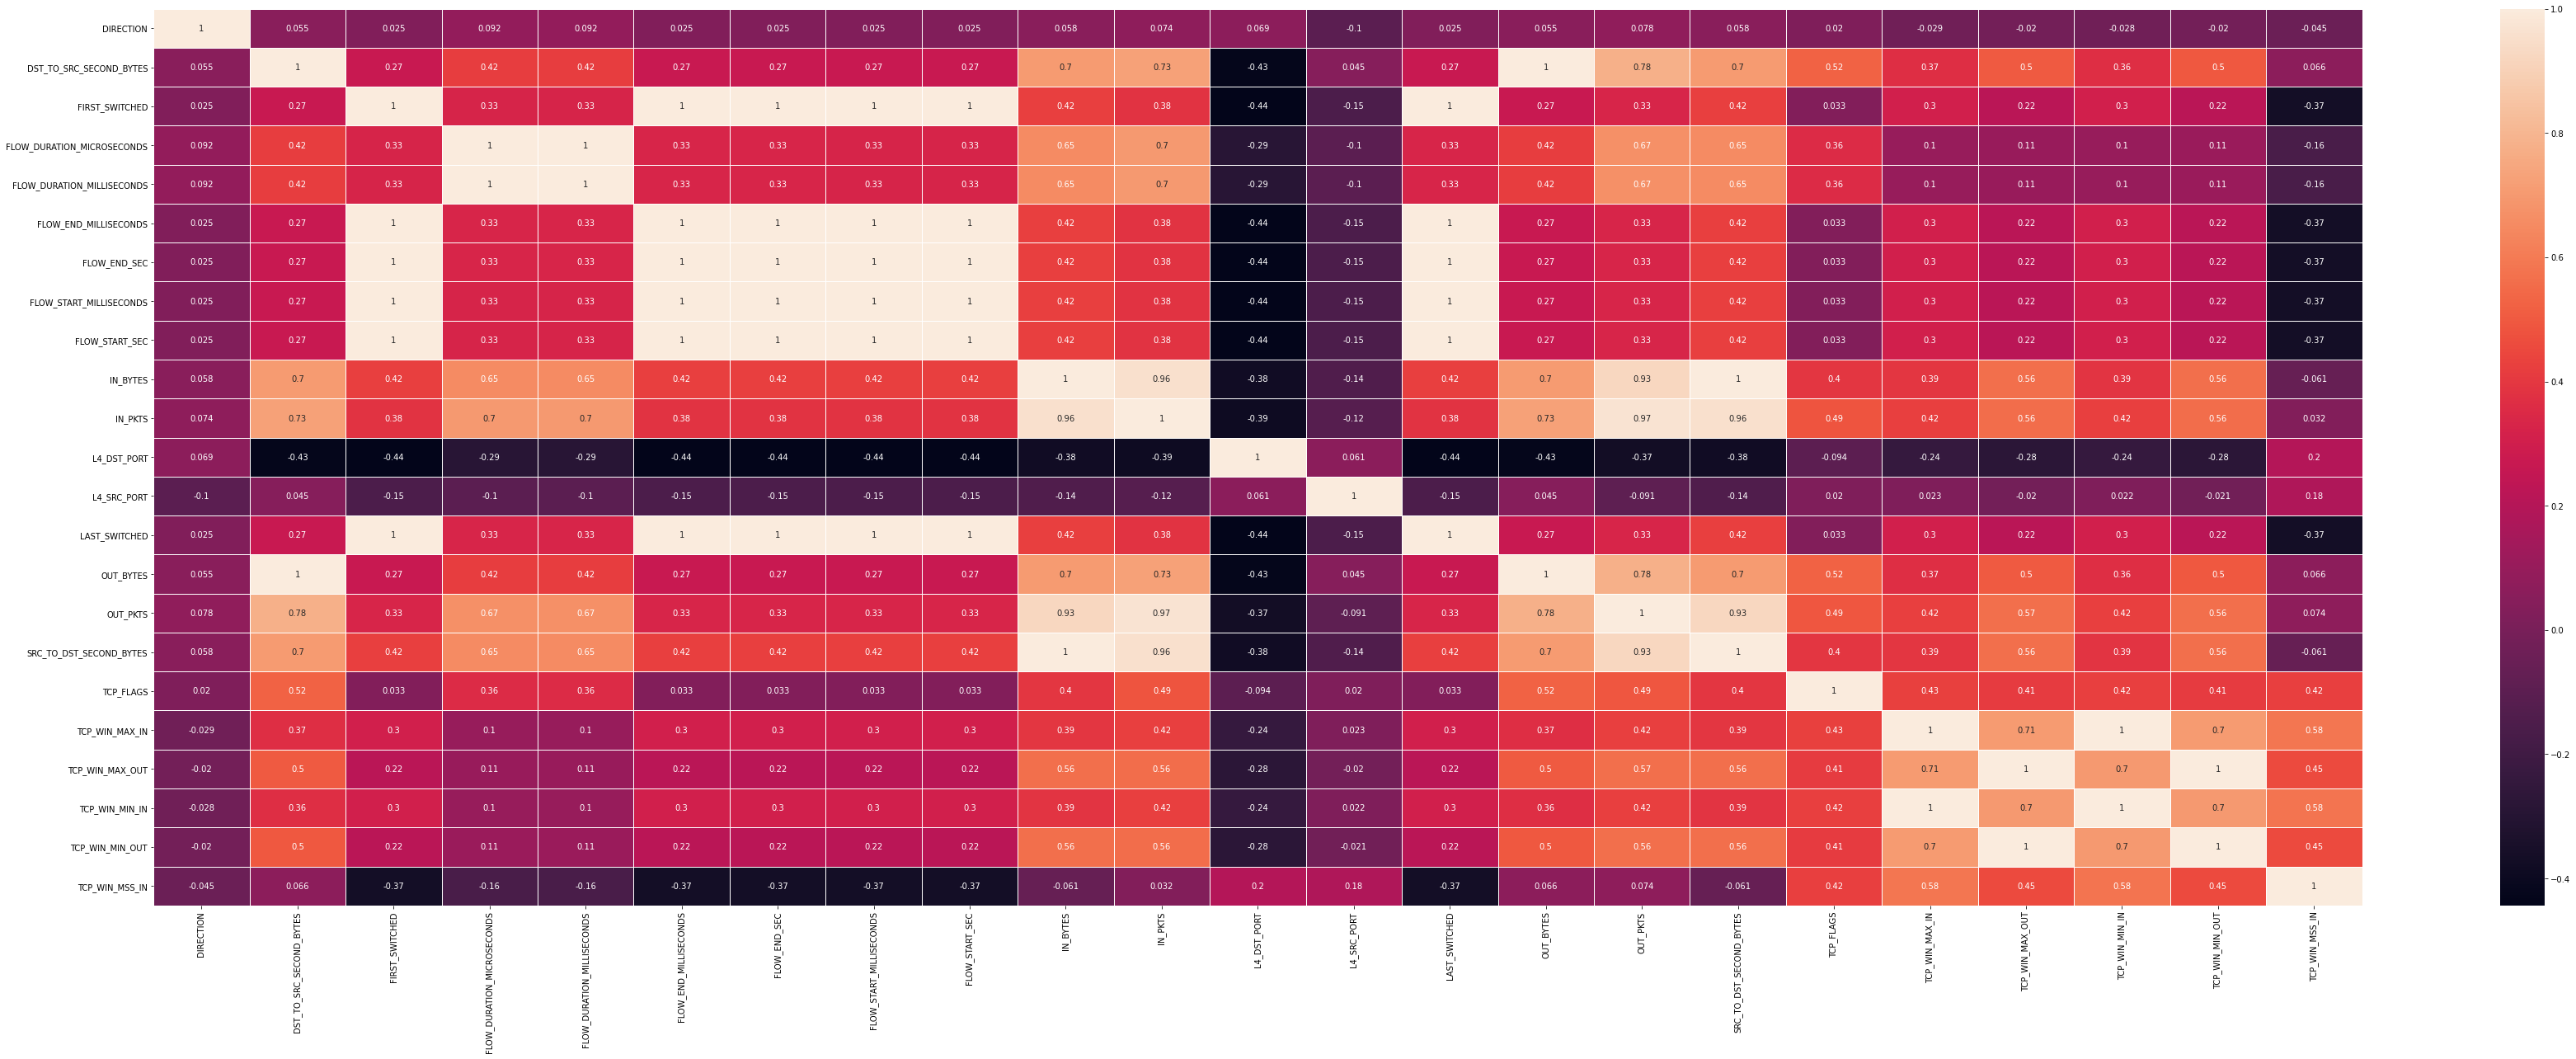

In [107]:
fig, ax = plt.subplots(figsize=(60,20)) 
sn.heatmap(corrMatrix, annot=True, linewidths=.5, ax=ax)
plt.show()

In [164]:
# df = safe_df_corr.copy()
# safe_df_corr = df.copy()
corrMatrix = df.corr()
for column in corrMatrix:
        correl = []
        for index in corrMatrix[column].index:
            if column != index and abs(corrMatrix[column][index]) >= 0.35:
                correl.append((index, corrMatrix[column][index]))
        if len(correl) > 0:
            print("La columna ", column, " tuvo correlación con las columnas")
            print(correl)
            print("\n")

In [162]:
# Remove useless columns
columns_to_drop = [
    "DST_TO_SRC_SECOND_BYTES", "FLOW_END_MILLISECONDS", "FLOW_END_SEC", "FLOW_START_MILLISECONDS", 
    "FLOW_START_SEC",
    "FLOW_DURATION_MICROSECONDS",
    "FLOW_DURATION_MILLISECONDS",
#     "IN_BYTES",
    "TCP_WIN_MIN_OUT", 
    "TCP_WIN_MIN_IN", 
    "TCP_WIN_MAX_IN",
    "TCP_WIN_MAX_OUT", 
    "L4_DST_PORT", 
    "OUT_BYTES", 
    "SRC_TO_DST_SECOND_BYTES", 
    "LAST_SWITCHED",
     "IN_BYTES", 
    "OUT_PKTS", 
    "L4_SRC_PORT",
    "TCP_WIN_MSS_IN",
    "TCP_FLAGS",
    "FIRST_SWITCHED",
]
df = df.drop(columns=columns_to_drop, axis = 1)

### Categorical variables preprocessing

#### Create PROTOCOL_MAP dummies

In [165]:
# Create the dummies
df = pd.get_dummies(df, columns = ["PROTOCOL_MAP"])
df.head(3)

,DIRECTION,IN_PKTS,L7_PROTO_NAME,LABEL,PROTOCOL_MAP_gre,PROTOCOL_MAP_icmp,PROTOCOL_MAP_ipv6-icmp,PROTOCOL_MAP_tcp,PROTOCOL_MAP_udp
0,0,0.000000,Unknown,Normal flow,0,0,0,1,0
1,0,0.000000,ICMP,Normal flow,0,1,0,0,0
2,0,0.693147,TLS,Normal flow,0,0,0,1,0


#### L7_PROTO_NAME dummies

In [166]:
l7 = df["L7_PROTO_NAME"]
df["L7_PROTO_NAME"].unique()

array(['Unknown', 'ICMP', 'TLS', 'TLS.Google', 'TLS.Teams', 'SMBv23',
       'TLS.Skype', 'DNS.Teams', 'Google', 'DNS.Google', 'QUIC.Google',
       'DNS.OpenDNS', 'DNS', 'DNS.Microsoft365', 'DNS.Microsoft',
       'HTTP_Proxy', 'NFS', 'TLS.Dropbox', 'DNS.Cloudflare', 'SSH', 'RDP',
       'TLS.Cloudflare', 'Telnet', 'BitTorrent', 'BGP', 'HTTP', 'NTP',
       'DNS.Yahoo', 'TLS.Microsoft365', 'MsSQL-TDS', 'DNS.Dropbox',
       'TeamViewer', 'Memcached', 'TLS.Amazon', 'TLS.Telegram', 's7comm',
       'DNS.WhatsApp', 'TLS.WhatsApp', 'MDNS', 'TLS.Microsoft',
       'HTTP.Google', 'SIP', 'DNS.GoogleServices', 'TLS.GoogleServices',
       'NTP.Cloudflare', 'HTTP.TeamViewer', 'LDAP', 'TLS.WhatsAppFiles',
       'DNS.Amazon', 'SNMP', 'COAP.DTLS', 'DNS.Facebook', 'TLS.Yahoo',
       'TLS.TeamViewer', 'QUIC.Facebook', 'DNS.MS_OneDrive', 'DNS.Skype',
       'TLS.Tor', 'Amazon', 'IMAPS', 'TLS.MS_OneDrive', 'CiscoSkinny',
       'WhatsAppFiles', 'DNS.UbuntuONE', 'HTTP.UbuntuONE',
       'DNS.GoogleD

In [167]:
df["L7_PROTO_NAME"] = df["L7_PROTO_NAME"].map(lambda protocol: utils.lematize_protocol(protocol).upper())

In [168]:
print(len(df["L7_PROTO_NAME"].unique()))

df["L7_PROTO_NAME"].unique()

132


array(['UNKNOWN', 'ICMP', 'TLS', 'SMBV23', 'DNS', 'GOOGLE', 'QUIC',
       'HTTP_PROXY', 'NFS', 'SSH', 'RDP', 'TELNET', 'BITTORRENT', 'BGP',
       'HTTP', 'NTP', 'MSSQL-TDS', 'TEAMVIEWER', 'MEMCACHED', 'S7COMM',
       'MDNS', 'SIP', 'LDAP', 'SNMP', 'COAP', 'AMAZON', 'IMAPS',
       'CISCOSKINNY', 'WHATSAPPFILES', 'POPS', 'SSDP', 'RTSP', 'POP3',
       'VNC', 'NETBIOS', 'FTP_CONTROL', 'H323', 'SMTP', 'MYSQL',
       'DCE_RPC', 'SMTPS', 'IMAP', 'REMOTESCAN', 'IAX', 'IEC60870',
       'MQTT', 'APPLE', 'RTP', 'MONGODB', 'FTP_DATA', 'SOMEIP',
       'POSTGRESQL', 'MODBUS', 'OPENVPN', 'STEAM', 'CISCOVPN',
       'PLAYSTATION', 'SKYPE', 'NESTLOGSINK', 'DNP3', 'STUN', 'WSD',
       'XBOX', 'TARGUSDATASPEED', 'AFP', 'LOTUSNOTES', 'KERBEROS',
       'RADIUS', 'SYSLOG', 'WHOIS-DAS', 'TFTP', 'IPSEC', 'IRC', 'OSPF',
       'XDMCP', 'MINING', 'VIBER', 'REDIS', 'ZABBIX', 'AJP', 'SOCKS',
       'LLMNR', 'TOR', 'ORACLE', 'CHECKMK', 'CITRIX', 'SAP', 'STARCRAFT',
       'GIT', 'DOH_DOT', 'RTMP', 'RSYNC

In [169]:
df = pd.get_dummies(df, columns = ["L7_PROTO_NAME"])
df.head(3)

,DIRECTION,IN_PKTS,LABEL,PROTOCOL_MAP_gre,PROTOCOL_MAP_icmp,PROTOCOL_MAP_ipv6-icmp,PROTOCOL_MAP_tcp,PROTOCOL_MAP_udp,L7_PROTO_NAME_AFP,L7_PROTO_NAME_AJP,...,L7_PROTO_NAME_WEBEX,L7_PROTO_NAME_WHATSAPP,L7_PROTO_NAME_WHATSAPPFILES,L7_PROTO_NAME_WHOIS-DAS,L7_PROTO_NAME_WIREGUARD,L7_PROTO_NAME_WSD,L7_PROTO_NAME_XBOX,L7_PROTO_NAME_XDMCP,L7_PROTO_NAME_ZABBIX,L7_PROTO_NAME_ZOOM
0,0,0.000000,Normal flow,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0.000000,Normal flow,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0.693147,Normal flow,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Treat LABEL column

In [170]:
df["LABEL"].unique()

array(['Normal flow', 'SYN Scan - aggressive',
       'Denial of Service R-U-Dead-Yet', 'Denial of Service Slowloris'],
      dtype=object)

In [171]:
labels_dic = {
    "Normal flow": 0,
    "SYN Scan - aggressive": 1,
    "Denial of Service R-U-Dead-Yet": 2,
    "Denial of Service Slowloris": 3
}
df["LABEL"] = df["LABEL"].apply(lambda x: labels_dic[x])
df["LABEL"].unique()

array([0, 1, 2, 3])

### Normalize column names

In [172]:
# Normalize columns
df.columns = [column.replace("-", "_") for column in df.columns]
df.columns

Index(['DIRECTION', 'IN_PKTS', 'LABEL', 'PROTOCOL_MAP_gre',
       'PROTOCOL_MAP_icmp', 'PROTOCOL_MAP_ipv6_icmp', 'PROTOCOL_MAP_tcp',
       'PROTOCOL_MAP_udp', 'L7_PROTO_NAME_AFP', 'L7_PROTO_NAME_AJP',
       ...
       'L7_PROTO_NAME_WEBEX', 'L7_PROTO_NAME_WHATSAPP',
       'L7_PROTO_NAME_WHATSAPPFILES', 'L7_PROTO_NAME_WHOIS_DAS',
       'L7_PROTO_NAME_WIREGUARD', 'L7_PROTO_NAME_WSD', 'L7_PROTO_NAME_XBOX',
       'L7_PROTO_NAME_XDMCP', 'L7_PROTO_NAME_ZABBIX', 'L7_PROTO_NAME_ZOOM'],
      dtype='object', length=140)

### Third profile report

In [173]:
df.shape

(12207873, 140)

In [127]:
if not os.path.isfile("profile-categorical.html") and generate_reports:
    profile = ProfileReport(df, title="Exploratory Data Analysis 2")
    profile.to_file("profile-categorical.html")

### Dataset balancing

In [174]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

ros = RandomOverSampler(sampling_strategy='minority')

In [175]:
normal_flow = df.loc[df["LABEL"] == 0]
syn_attacks = df.loc[df["LABEL"] == 1]
r_u_dead_attacks = df.loc[df["LABEL"] == 2]
dos_attacks = df.loc[df["LABEL"] == 3]

In [176]:
print(len(normal_flow))
print(len(syn_attacks))
print(len(r_u_dead_attacks))
print(len(dos_attacks))

6570058
2496814
2276947
864054


#### Oversampling DDoS attack

In [177]:
attacks_oversampling = pd.concat([syn_attacks, dos_attacks])
y_oversampling = attacks_oversampling["LABEL"]
x_oversampling = attacks_oversampling.drop(["LABEL"], axis= 1)

In [178]:
y_oversampling

3060        1
3071        1
3073        1
3074        1
3076        1
           ..
11513523    3
11513526    3
11513568    3
11513569    3
11513579    3
Name: LABEL, Length: 3360868, dtype: int64

In [179]:
x_oversampling

,DIRECTION,IN_PKTS,PROTOCOL_MAP_gre,PROTOCOL_MAP_icmp,PROTOCOL_MAP_ipv6_icmp,PROTOCOL_MAP_tcp,PROTOCOL_MAP_udp,L7_PROTO_NAME_AFP,L7_PROTO_NAME_AJP,L7_PROTO_NAME_AMAZON,...,L7_PROTO_NAME_WEBEX,L7_PROTO_NAME_WHATSAPP,L7_PROTO_NAME_WHATSAPPFILES,L7_PROTO_NAME_WHOIS_DAS,L7_PROTO_NAME_WIREGUARD,L7_PROTO_NAME_WSD,L7_PROTO_NAME_XBOX,L7_PROTO_NAME_XDMCP,L7_PROTO_NAME_ZABBIX,L7_PROTO_NAME_ZOOM
3060,0,0.000000,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3071,0,0.000000,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3073,0,0.000000,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3074,0,0.000000,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3076,0,0.000000,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11513523,0,1.791759,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11513526,0,2.079442,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11513568,0,1.945910,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11513569,0,2.079442,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [180]:
X_oversampling_res, y_oversampling_res = ros.fit_resample(x_oversampling, y_oversampling)

In [181]:
print('Resampled dataset shape %s' % Counter(y_oversampling_res))

Resampled dataset shape Counter({1: 2496814, 3: 2496814})


In [182]:
oversampling_result = X_oversampling_res.copy()
oversampling_result["LABEL"] = y_oversampling_res.copy()

In [183]:
sampled_df = pd.concat([normal_flow, r_u_dead_attacks, oversampling_result])

In [184]:
oversampled_safe_df = sampled_df.copy()

#### Undersampling benign

In [185]:
from imblearn.under_sampling import RandomUnderSampler

In [186]:
normal_flow = sampled_df.loc[sampled_df["LABEL"] == 0]
syn_attacks = sampled_df.loc[sampled_df["LABEL"] == 1]
r_u_dead_attacks = sampled_df.loc[sampled_df["LABEL"] == 2]
dos_attacks = sampled_df.loc[sampled_df["LABEL"] == 3]

In [187]:
benign_us = pd.concat([syn_attacks, normal_flow])

In [188]:
y = benign_us["LABEL"]
X = benign_us.drop(["LABEL"], axis=1)

In [189]:
rus = RandomUnderSampler(random_state=0)

In [190]:
X_undersampled, y_undersampled = rus.fit_resample(X, y)

print('Resampled dataset shape %s' % Counter(y_undersampled))

Resampled dataset shape Counter({0: 2496814, 1: 2496814})


In [191]:
X_undersampled["LABEL"] = y_undersampled
undersample_res = X_undersampled

In [192]:
sampled_df = pd.concat([dos_attacks, r_u_dead_attacks, undersample_res])

### Create clean dataset

In [193]:
sampled_df.groupby('LABEL', group_keys=False).apply(lambda x: x.sample(frac=0.05)).to_csv("dataset/clean_df.csv")
# sampled_df.to_csv("dataset/clean_df.csv")

In [194]:
sampled_df.columns

Index(['DIRECTION', 'IN_PKTS', 'LABEL', 'PROTOCOL_MAP_gre',
       'PROTOCOL_MAP_icmp', 'PROTOCOL_MAP_ipv6_icmp', 'PROTOCOL_MAP_tcp',
       'PROTOCOL_MAP_udp', 'L7_PROTO_NAME_AFP', 'L7_PROTO_NAME_AJP',
       ...
       'L7_PROTO_NAME_WEBEX', 'L7_PROTO_NAME_WHATSAPP',
       'L7_PROTO_NAME_WHATSAPPFILES', 'L7_PROTO_NAME_WHOIS_DAS',
       'L7_PROTO_NAME_WIREGUARD', 'L7_PROTO_NAME_WSD', 'L7_PROTO_NAME_XBOX',
       'L7_PROTO_NAME_XDMCP', 'L7_PROTO_NAME_ZABBIX', 'L7_PROTO_NAME_ZOOM'],
      dtype='object', length=140)

In [195]:
for column in sampled_df.columns:
    print(column)

DIRECTION
IN_PKTS
LABEL
PROTOCOL_MAP_gre
PROTOCOL_MAP_icmp
PROTOCOL_MAP_ipv6_icmp
PROTOCOL_MAP_tcp
PROTOCOL_MAP_udp
L7_PROTO_NAME_AFP
L7_PROTO_NAME_AJP
L7_PROTO_NAME_AMAZON
L7_PROTO_NAME_AMONGUS
L7_PROTO_NAME_APPLE
L7_PROTO_NAME_AYIYA
L7_PROTO_NAME_BGP
L7_PROTO_NAME_BITTORRENT
L7_PROTO_NAME_BJNP
L7_PROTO_NAME_BLOOMBERG
L7_PROTO_NAME_CAPWAP
L7_PROTO_NAME_CHECKMK
L7_PROTO_NAME_CISCOSKINNY
L7_PROTO_NAME_CISCOVPN
L7_PROTO_NAME_CITRIX
L7_PROTO_NAME_CLOUDFLARE
L7_PROTO_NAME_COAP
L7_PROTO_NAME_COLLECTD
L7_PROTO_NAME_CORBA
L7_PROTO_NAME_DCE_RPC
L7_PROTO_NAME_DIAMETER
L7_PROTO_NAME_DNP3
L7_PROTO_NAME_DNS
L7_PROTO_NAME_DOH_DOT
L7_PROTO_NAME_DROPBOX
L7_PROTO_NAME_DTLS
L7_PROTO_NAME_EAQ
L7_PROTO_NAME_FACEBOOK
L7_PROTO_NAME_FTP_CONTROL
L7_PROTO_NAME_FTP_DATA
L7_PROTO_NAME_GIT
L7_PROTO_NAME_GOOGLE
L7_PROTO_NAME_GRE
L7_PROTO_NAME_GTP
L7_PROTO_NAME_H323
L7_PROTO_NAME_HOTSPOTSHIELD
L7_PROTO_NAME_HTTP
L7_PROTO_NAME_HTTP_PROXY
L7_PROTO_NAME_IAX
L7_PROTO_NAME_ICMP
L7_PROTO_NAME_ICMPV6
L7_PROTO_NAME_IEC608

In [196]:
len(sampled_df.columns)

140